<a href="https://colab.research.google.com/github/cosmo3769/keras.io_examples/blob/main/computer%20vision/Segformer_tf_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

[Segformer_tf_finetune](https://github.com/deep-diver/segformer-tf-transformers/blob/main/notebooks/TFSegFormer_Finetune.ipynb)

[Fine-Tune a Semantic Segmentation Model with a Custom Dataset](https://huggingface.co/blog/fine-tune-segformer)

In [ ]:
!pip -q install datasets==2.3.2
!pip -q install huggingface-hub==0.8.1

     |████████████████████████████████| 362 kB 36.3 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 163 kB 71.8 MB/s 
     |████████████████████████████████| 115 kB 69.6 MB/s 
     |████████████████████████████████| 212 kB 68.5 MB/s 
     |████████████████████████████████| 127 kB 71.9 MB/s 
     |████████████████████████████████| 115 kB 72.9 MB/s 
     |████████████████████████████████| 101 kB 7.1 MB/s 


In [ ]:
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 38.3 MB/s 


In [ ]:
# Ensure we have access to a GPU.
!nvidia-smi

Tue Nov  1 14:41:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric
from huggingface_hub import cached_download, hf_hub_url
from tensorflow.keras.optimizers import Adam

from transformers import (
    DefaultDataCollator,
    SegformerFeatureExtractor,
    TFSegformerForSemanticSegmentation,
    create_optimizer,
)
from transformers.keras_callbacks import KerasMetricCallback

In [ ]:
epochs = 2
lr = 0.00006
batch_size = 2

In [ ]:
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-007b1ee78ca1e890/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
val_ds = ds["test"]

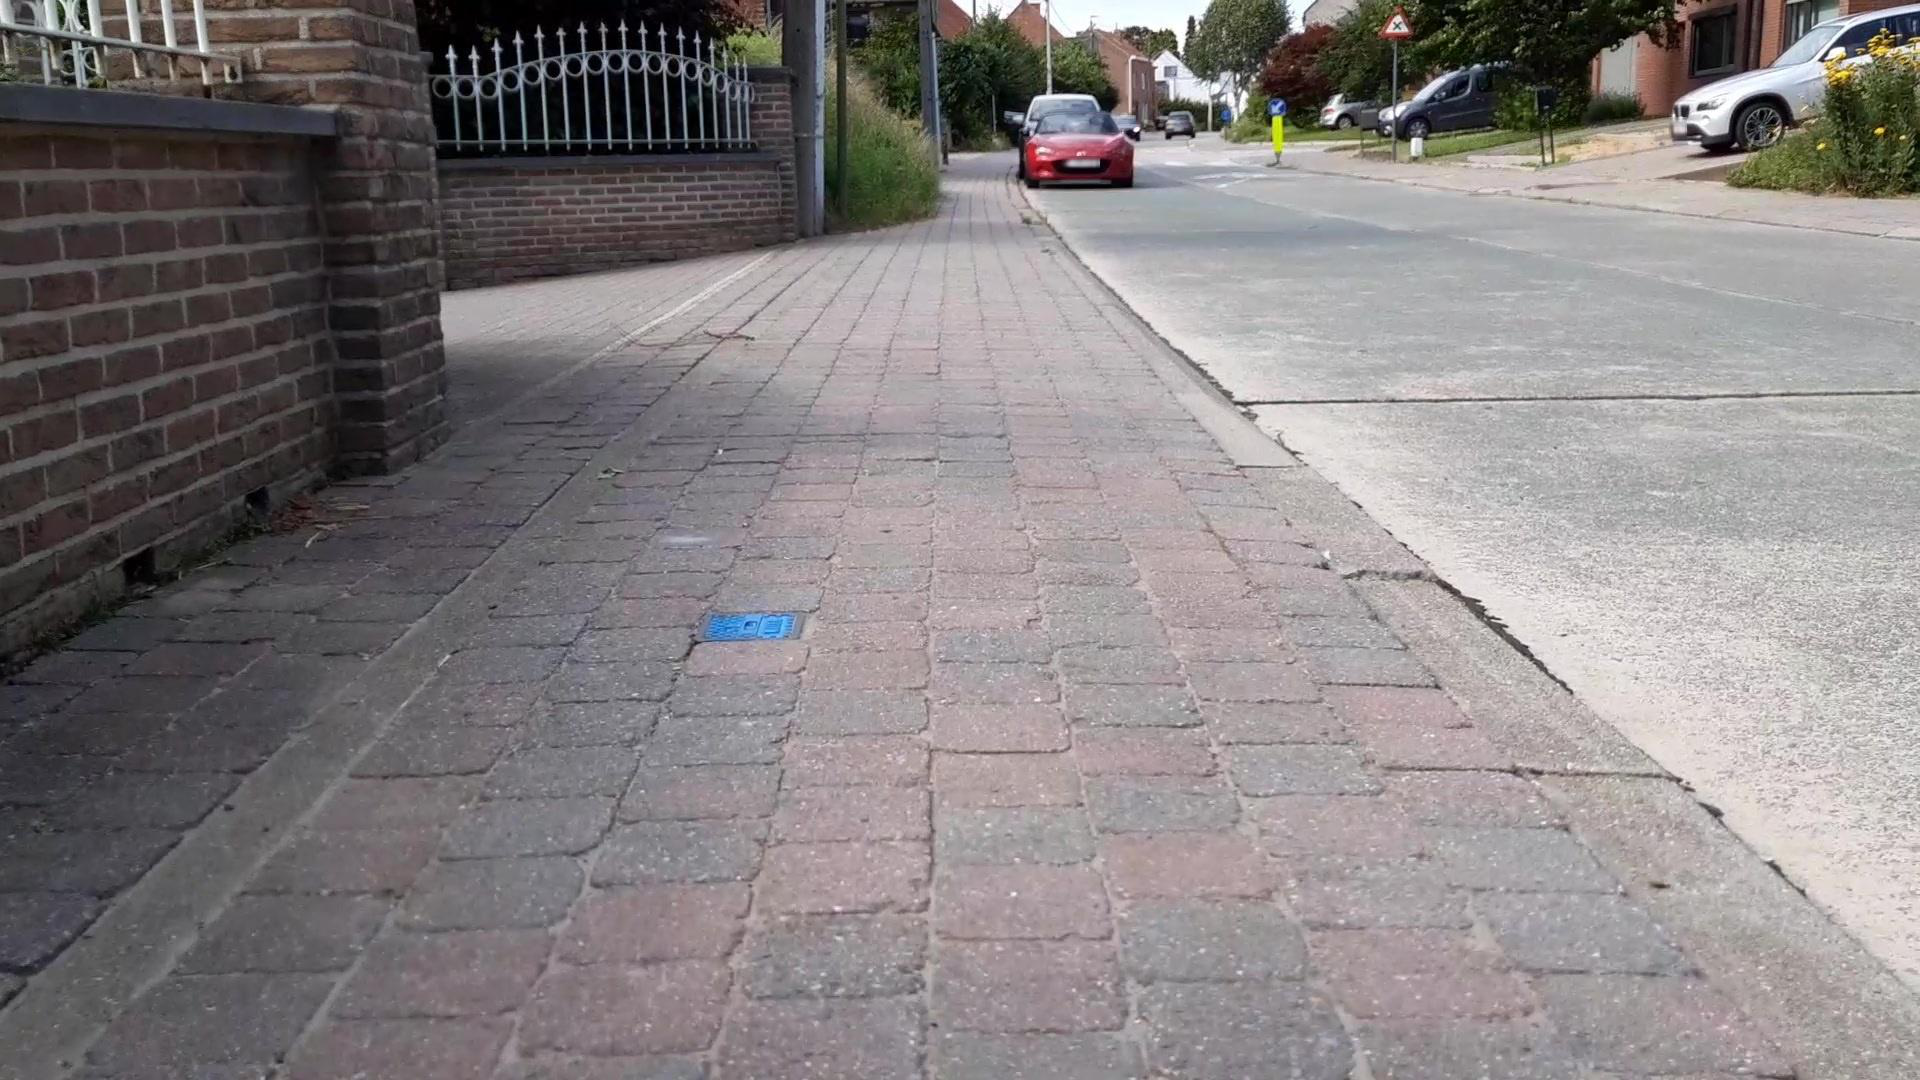

In [ ]:
# Preview an image.
train_ds[0]["pixel_values"]

In [9]:
repo_id = f"datasets/{hf_dataset_identifier}"
filename = "id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:591: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/852 [00:00<?, ?B/s]

In [10]:
feature_extractor = SegformerFeatureExtractor()


def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose((2, 0, 1))
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB")) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [11]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)

In [12]:
# Preview the features of `train_ds`.
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

In [13]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [14]:
# Look at the shapes of each features within the dataset.
train_set.element_spec

{'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int64, name=None),
 'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None)}

In [15]:
# Investigate a single batch.
batch = next(iter(train_set))
batch["pixel_values"].shape, batch["labels"].shape

(TensorShape([2, 3, 512, 512]), TensorShape([2, 512, 512]))

In [16]:
metric = load_metric("mean_iou")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=-1,
        reduce_labels=feature_extractor.reduce_labels,
    )
    return {"val_" + k: v for k, v in metrics.items()}


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_set,
    batch_size=batch_size,
    label_cols=["labels"],
)

In [17]:
model_checkpoint = "nvidia/mit-b0"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

optimizer = Adam(learning_rate=lr)
model.compile(optimizer)

Downloading:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the 

In [18]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMainL  multiple                 3319392   
 ayer)                                                           
                                                                 
 decode_head (TFSegformerDec  multiple                 404259    
 odeHead)                                                        
                                                                 
Total params: 3,723,651
Trainable params: 3,723,139
Non-trainable params: 512
_________________________________________________________________


In [19]:
# Dummy forward pass.
outputs = model(batch)
outputs.loss, outputs.logits.shape

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.588834], dtype=float32)>,
 TensorShape([2, 35, 128, 128]))

In [20]:
callbacks = [metric_callback] 

In [21]:
model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
)

Epoch 1/2
400/400 [==============================] - ETA: 0s - loss: 1.3956

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


400/400 [==============================] - 474s 1s/step - loss: 1.3956 - val_loss: 0.8782 - val_mean_iou: 0.1761 - val_mean_accuracy: 0.2253 - val_overall_accuracy: 0.7609 - val_per_category_iou: nan - val_per_category_accuracy: nan
Epoch 2/2
400/400 [==============================] - 445s 1s/step - loss: 0.8414 - val_loss: 0.7168 - val_mean_iou: 0.2224 - val_mean_accuracy: 0.2740 - val_overall_accuracy: 0.7959 - val_per_category_iou: nan - val_per_category_accuracy: nan


In [22]:
eval_loss = model.evaluate(val_set)
eval_loss

100/100 [==============================] - 33s 331ms/step - loss: 0.7168


0.7167797684669495

In [25]:
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
inference = ds["test"]

  0%|          | 0/1 [00:00<?, ?it/s]

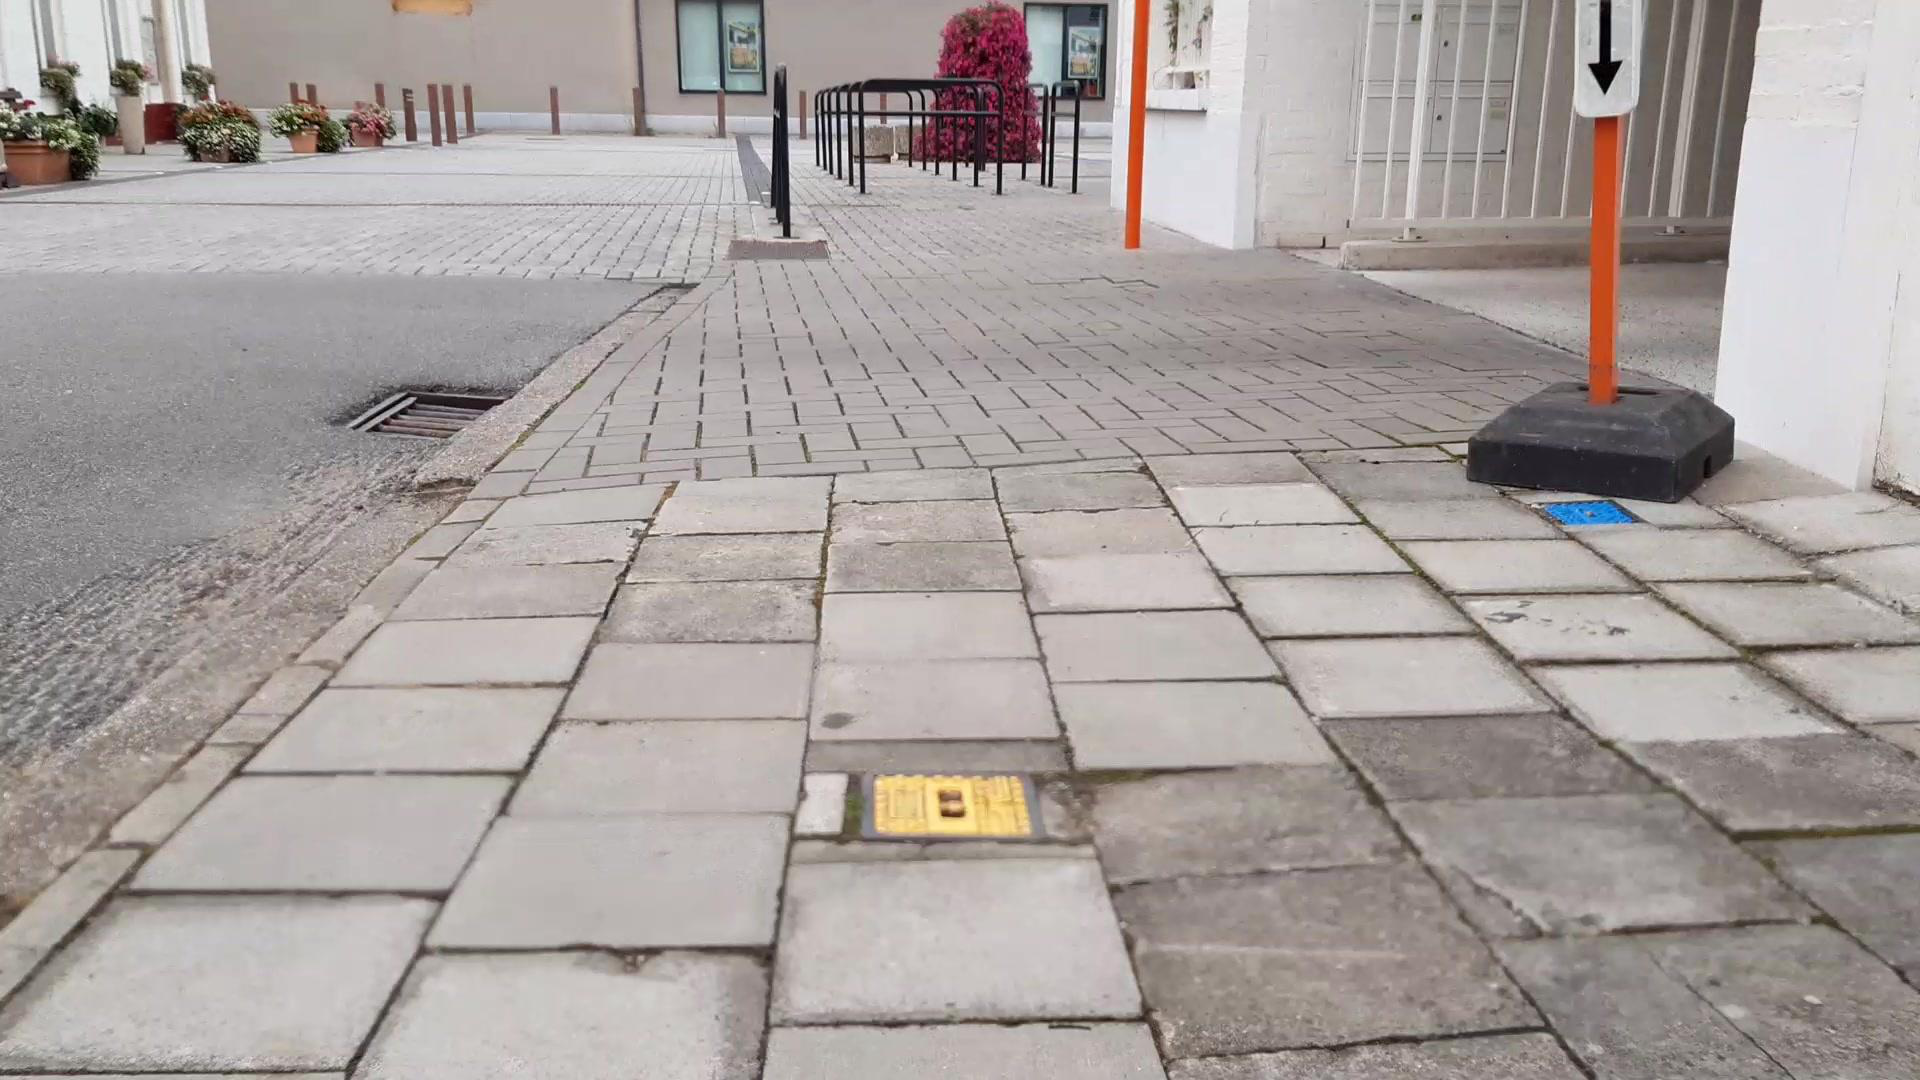

In [26]:
test_image = inference[0]["pixel_values"]
test_gt = inference[0]["label"]
test_image

In [27]:
inputs = feature_extractor(images=test_image, return_tensors="tf")
print(inputs["pixel_values"].shape)

(1, 3, 512, 512)


In [29]:
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# First, rescale logits to original image size
upsampled_logits = tf.image.resize(
    logits,
    test_image.size[
        ::-1
    ],  # We reverse the shape of `image` because `image.size` returns width and height.
)

# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
print(pred_seg.shape)

(1080, 1920)


In [30]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [31]:
def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

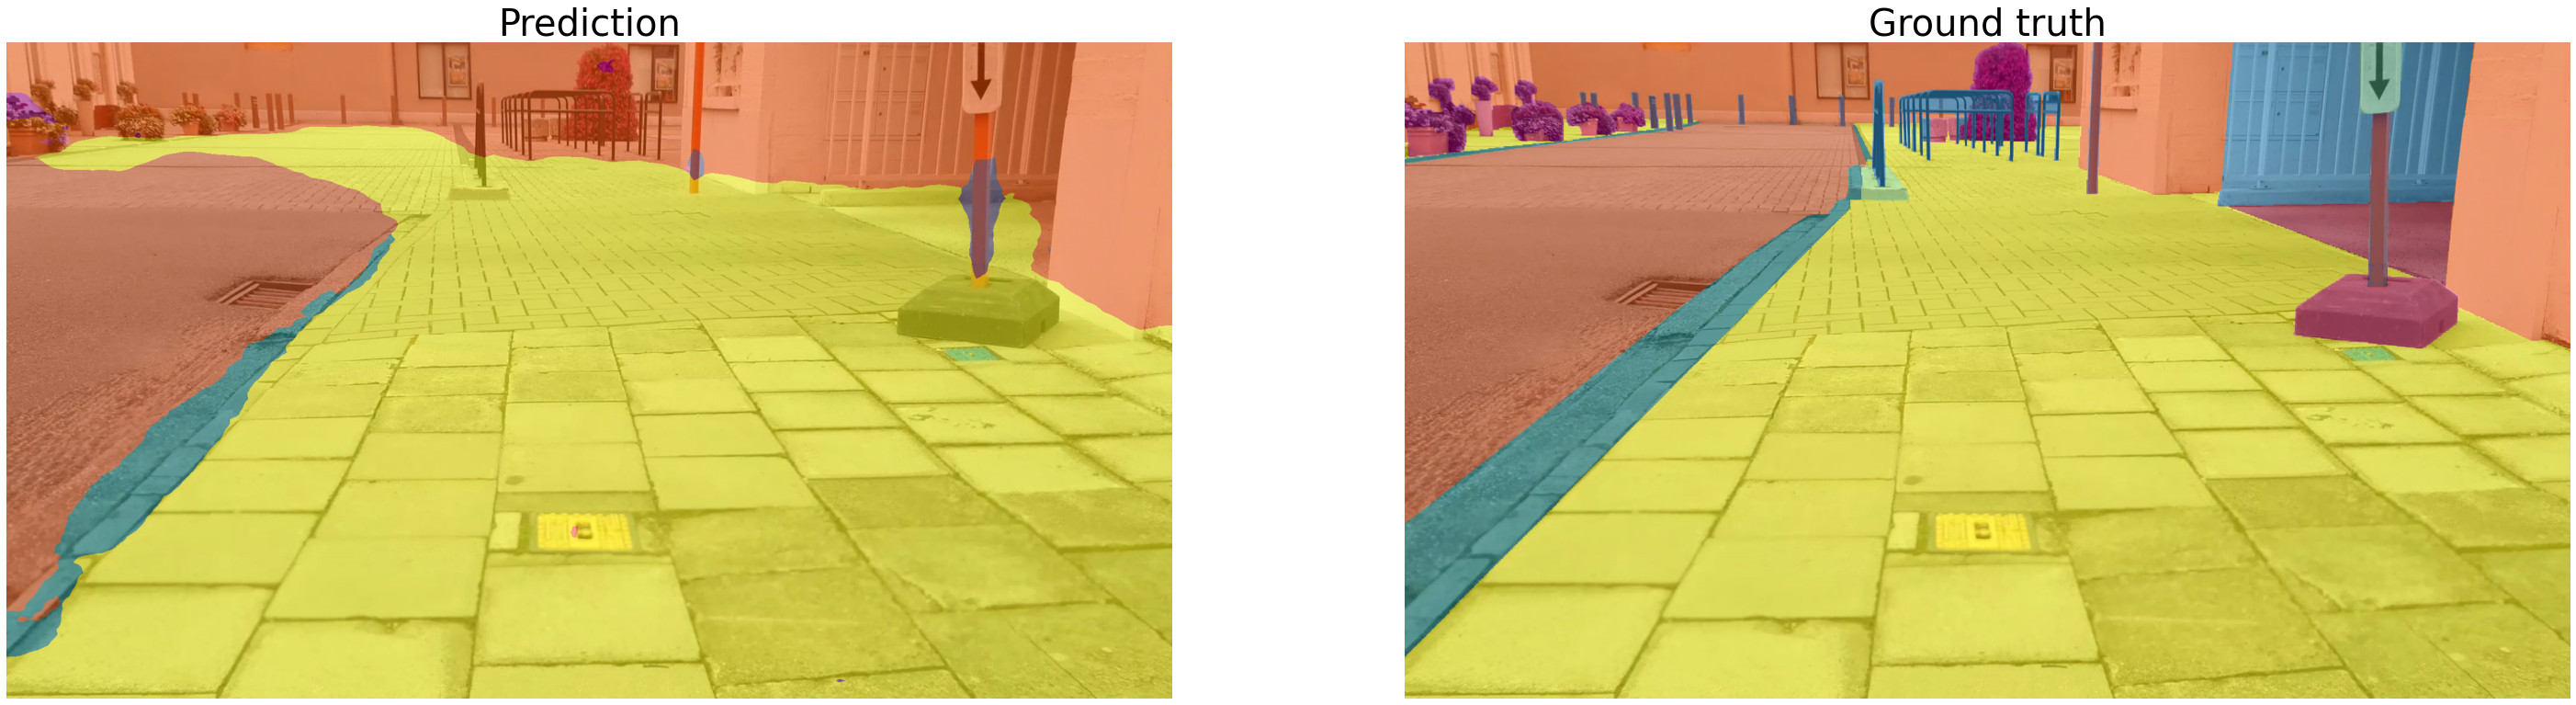

In [32]:
pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()